# **Database & DBUtils**

In [ ]:
try:
  !pip install mysql-connector >> /dev/null
  import mysql.connector
  import datetime

  decidemadrid_db = mysql.connector.connect(
    host="XXXXXXXXX",
    port="XXXXXXXXX",
    database="XXXXXXXXX",
    user="XXXXXXXXX",
    passwd="XXXXXXXXX"
  )

  db_cursor = decidemadrid_db.cursor(buffered=True)

  print("DB connection stablished successfully")
except e:
  print('Error: ' + str(e))

DB connection stablished successfully


In [ ]:
# USAGE: db_query_select('*','proposals','id=1035')
def db_query_select(select_param, from_param, where_param=None, extra_param=None, encoding='iso-8859-1'):
  
  # Generate query
  str_select = "select " + ''. join(select_param)
  str_from = " from " + ''.join(from_param + " ")
  str_where = "" if not where_param else " where " + ''.join(where_param + " ")
  str_extra = "" if not extra_param else ''.join(extra_param + " ")
  qry = str_select + str_from + str_where + str_extra
  
  # Print query
  print(qry)
  
  # Execute and fetch results
  db_cursor.execute(qry)
  qry_result = db_cursor.fetchall()

  # Transform the result into list of lists without bytearrays
  result = []
  for row in qry_result:
    # print(row)
    clean_attributes = []
    for attribute in row:
      try:
        clean_attributes.append(attribute.decode(encoding))
      except:
        clean_attributes.append(attribute)
    result.append(clean_attributes)
  return result


## **Correlating controversy with support**

In [ ]:
#db_query_select('url','proposals')
!pip install scrapely

from scrapely import Scraper

     |████████████████████████████████| 163kB 2.7MB/s 
  Created wheel for scrapely: filename=scrapely-0.14.1-cp36-cp36m-linux_x86_64.whl size=444113 sha256=e2914a52a0eb9a09074e01704f03c167ad6cc9c5a76ae31f12ff4ba47b625c6f
  Stored in directory: /root/.cache/pip/wheels/96/59/6e/44437bc84cab0a590012ad32b944737b0e6877e032fc616c54
Successfully built scrapely


In [ ]:
 numSupports_aggregation = db_query_select('a.id, a.numSupports, b.value','proposals a, metrics_controversy b', 'a.id=b.proposalId and b.name="AGGREGATION"', 'order by a.id')
 numSupports_conv_structure = db_query_select('a.id, a.numSupports, b.value','proposals a, metrics_controversy b', 'a.id=b.proposalId and b.name="CONVERSATION_STRUCTURE"', 'order by a.id')
 numSupports_disc_content = db_query_select('a.id, a.numSupports, b.value','proposals a, metrics_controversy b', 'a.id=b.proposalId and b.name="DISCUSSION_CONTENT"', 'order by a.id')
 numSupports_polaritzation = db_query_select('a.id, a.numSupports, b.value','proposals a, metrics_controversy b', 'a.id=b.proposalId and b.name="OPINION_POLARIZATION"', 'order by a.id')

select a.id, a.numSupports, b.value from proposals a, metrics_controversy b  where a.id=b.proposalId and b.name="AGGREGATION" order by a.id 
select a.id, a.numSupports, b.value from proposals a, metrics_controversy b  where a.id=b.proposalId and b.name="CONVERSATION_STRUCTURE" order by a.id 
select a.id, a.numSupports, b.value from proposals a, metrics_controversy b  where a.id=b.proposalId and b.name="DISCUSSION_CONTENT" order by a.id 
select a.id, a.numSupports, b.value from proposals a, metrics_controversy b  where a.id=b.proposalId and b.name="OPINION_POLARIZATION" order by a.id 


,numSupports,aggregation,conversation_structure,discussion_content,opinion_polarization
numSupports,1.000000,0.345495,0.283194,0.229482,0.331924
aggregation,0.345495,1.000000,0.851158,0.848132,0.652617
conversation_structure,0.283194,0.851158,1.000000,0.591813,0.377928
discussion_content,0.229482,0.848132,0.591813,1.000000,0.319859
opinion_polarization,0.331924,0.652617,0.377928,0.319859,1.000000


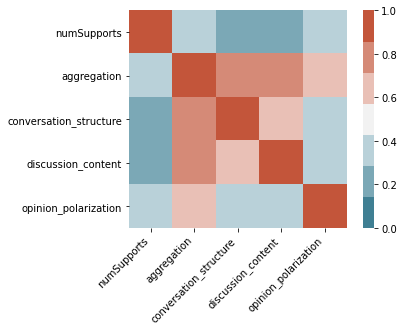

In [ ]:
import pandas as pd
import seaborn as sns

# Convert the query results into dataframes
numSupports_aggregation_df = pd.DataFrame.from_records(numSupports_aggregation, columns=['id','numSupports','aggregation'])
numSupports_conv_structure_df = pd.DataFrame.from_records(numSupports_conv_structure, columns=['id','numSupports','conversation_structure'])
numSupports_disc_content_df = pd.DataFrame.from_records(numSupports_disc_content, columns=['id','numSupports','discussion_content'])
numSupports_polaritzation_df = pd.DataFrame.from_records(numSupports_polaritzation, columns=['id','numSupports','opinion_polarization'])

# Merge the dataframes into one
support_controversy_df = pd.merge(numSupports_aggregation_df,numSupports_conv_structure_df, on = ['id','numSupports'],how='inner')
support_controversy_df = support_controversy_df.merge(numSupports_disc_content_df,on = ['id','numSupports'],how='inner')
support_controversy_df = support_controversy_df.merge(numSupports_polaritzation_df,on = ['id','numSupports'],how='inner')
support_controversy_df = support_controversy_df.drop('id', axis=1)

corr = support_controversy_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(220, 20, n=7),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
corr


In [ ]:
x = db_query_select('b.district, c.topic, a.numSupports', 'proposals a, proposal_locations b, proposal_topics c','c.id=a.id and a.id=b.id')
proposal_loc_supp = pd.DataFrame.from_records(x, columns=['district','topic','num_supports'])
proposal_loc_supp = proposal_loc_supp.sort_values('num_supports', ascending=False)
proposal_loc_supp.head(10)

,district,topic,num_supports
59443,Fuencarral-El Pardo,sostenibilidad,20604
59442,Fuencarral-El Pardo,medio ambiente,20604
6219,Ciudad,ibi,19136
6220,Ciudad,inmuebles,19136
6221,Ciudad,la iglesia,19136
6222,Ciudad,transparencia,19136
6218,Ciudad,actividad economica,19136
58331,Ciudad,medio ambiente,16306
3349,Puente de Vallecas,igualdad,16188
3354,VicÃ¡lvaro,igualdad,16188


# **NLP**

In [ ]:

### TREETAGGER
!curl https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/tree-tagger-linux-3.2.2.tar.gz -o tree-tagger-linux-3.2.2.tar.gz
!curl https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/tagger-scripts.tar.gz -o tagger-scripts.tar.gz
!curl https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/install-tagger.sh -o install-tagger.sh
!curl https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/spanish.par.gz -o spanish.par.gz
!sh install-tagger.sh

# Hunspell -> Spell checking
#!curl https://github.com/elastic/hunspell/raw/master/zips/es_ES.zip -o es_ES.zip
!curl https://raw.githubusercontent.com/LibreOffice/dictionaries/master/es/es_ANY.aff -o es_ES.aff >> /dev/null
!curl https://raw.githubusercontent.com/LibreOffice/dictionaries/master/es/es_ANY.dic -o es_ES.dic >> /dev/null
!sudo apt update >> /dev/null
!sudo apt-get install python3.6-dev >> /dev/null
!sudo apt-get install libhunspell-dev >> /dev/null
!pip install hunspell >> /dev/null

#Spacy -> Get noun chunks
!pip install -U spacy >> /dev/null
!python -m spacy download es_core_news_md >> /dev/null

# Textdistance -> Similarity between list of strings (Jaccard index)
!pip install textdistance >> /dev/null

# Imports
import es_core_news_md
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
import textdistance
import hunspell
import re

# Adding custom names to spellchecking dictionaries:
# Neighborhoods
geo_neighborhoods = db_query_select('name','geo_neighborhoods',encoding='utf-8')
geo_neighborhoods = [element[0] for element in geo_neighborhoods]

# Districts
geo_districts = db_query_select('name','geo_districts',encoding='utf-8')
geo_districts = [element[0] for element in geo_districts]

# Streets
geo_streets = db_query_select('distinct street','geo_locations',encoding='utf-8')
geo_streets = [element[0].title() for element in geo_streets]

# Callejero Madrid
with open('/content/drive/My Drive/TFM/callejero_madrid.txt',encoding='iso-8859-1') as f:
  callejero = f.readlines()
callejero = [c.replace("\n",'') for c in callejero]

# Other Words
with open('/content/drive/My Drive/TFM/custom_dic.txt') as f:
    custom_words = f.readlines()

# Add
with open("es_ES.dic", "a") as myfile:

  myfile.write("\n")
  for element in geo_neighborhoods:
    myfile.write(element+"\n")
  for element in geo_districts:
    myfile.write(element+"\n")
  for element in geo_streets:
    myfile.write(element+"\n")
  for element in custom_words:
    myfile.write(element+"\n")
  for element in callejero:
    myfile.write(element+"\n")

# NLTK -> Stopwords
nltk.download('stopwords')
nltk.download('punkt')
spanish_stopwords = stopwords.words('spanish') # STOPWORDS
spanish_stopwords.append(',')

nlp = es_core_news_md.load() # SPACY

corrector = hunspell.HunSpell('es_ES.dic','es_ES.aff')  #CORRECTOR

# TREETAGGER WRAPPER
!pip install treetaggerwrapper
import treetaggerwrapper
import os
!export TAGDIR='/content/cmd'
os.environ['TAGDIR'] = '/content'

tagger = treetaggerwrapper.TreeTagger(TAGLANG='es')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1778k  100 1778k    0     0  1130k      0  0:00:01  0:00:01 --:--:-- 1130k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100k  100  100k    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13245  100 13245    0     0  18094      0 --:--:-- --:--:-- --:--:-- 18069
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  981k  100  981k    0     0   749k      0  0:00:01  0:00:01 --:--:--  749k

TreeTagger version for PC-Linux installed.
Tagging 

In [ ]:
def lemmatize(text, exceptions):
  # Dont lemmatize exceptions

  import subprocess

  res_lemmas = []

  cmd = "echo \'" + text + "\' | cmd/tree-tagger-spanish"
  print(cmd[:50])
  ps = subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
  output = ps.communicate()[0]
  output = output.decode("utf-8").split("\n")
  output = output[2:-2]

  treetagger_result = output
  lemmas = [lemma.split('\t') for lemma in treetagger_result]
  for lemma in lemmas:
    # Get the lemma
    if lemma[2] != '<unknown>' and lemma[2] != '@card@':
      actual_lemma = lemma[2]
    else:
      actual_lemma = lemma[0]

    # Get the category
    res_lemmas.append(actual_lemma)

  return res_lemmas

def clean_symbols(text, symbols = '/' ):
  for sym in symbols:
    if sym in text:
      text = text.replace(sym,' ')
  return text

def clean_stopwords(txt, exceptions):
  txt = txt.lower()

  filtered_sentence = [] 
  for e in exceptions:
    if bool(re.search(r'\b' + e.lower() + r'\b', txt)):
      filtered_sentence.append(e)
      txt = re.sub(r'\b' + e.lower() + r'\b', '', txt)

  word_tokens = word_tokenize(txt) 

  for w in word_tokens: 
    if w not in spanish_stopwords and len(w) > 2:
      filtered_sentence.append(w) 

  return " ".join(filtered_sentence)

def clean_stopwords_spacy(text, exceptions):
  text = text.lower()

  non_stopwords = []
  for e in exceptions:
    if bool(re.search(r'\b' + e.lower() + r'\b', text)):
      non_stopwords.append(e)
      text = re.sub(r'\b' + e.lower() + r'\b', '', text)

  doc = nlp(text)
  for token in doc:
    if token.is_stop == False:
      non_stopwords.append(token.text)

  return ' '.join(non_stopwords)

def get_noun_chunks(txt):
  doc = nlp(txt)
  words = []

  for i in doc.noun_chunks:
    # print(i)
    words.append(clean_stopwords(str(i)))
  words = list(filter(None, words))

  # Debería devolver una unica vez la palabra o todas las apariciones?
  # return words
  return list(set(words))

def spell_checking(text):
  newstr = []
  # print("Spellchecking '" + text + "'")

  for i in text.split(' '):
    newstr.append(corrector.suggest(i)[0] if not corrector.spell(i) and corrector.suggest(i) != [] else i)

  return ' '.join(newstr).lower()

def get_similar_nouns(words):
  context = []
  n = 3 # Only the three first words

  for i in words:
    try:
      context.append([i])  # Add the origin word(s) before similars

      # If it's a compound noun -> separate it
      if (' ' in i):
        i = i.split(' ')

      actual_context_raw = wordvectors.most_similar_cosmul(positive=i)[:n]
      context.append([word[0] for word in actual_context_raw])
    except:
      pass

  context = functools.reduce(operator.iconcat, context, []) # Flatten the list
  return context

In [ ]:
##### LEMMA EXCEPTIONS
lemma_exceptions = []

# Neighborhoods
geo_neighborhoods = db_query_select('name','geo_neighborhoods',encoding='utf-8')
geo_neighborhoods = [element[0] for element in geo_neighborhoods]

# Districts
geo_districts = db_query_select('name','geo_districts',encoding='utf-8')
geo_districts = [element[0] for element in geo_districts]

# Callejero
with open('/content/drive/My Drive/TFM/callejero_madrid.txt',encoding='utf-8') as f:
  callejero = f.readlines()
callejero = [c.replace("\n",'') for c in callejero]

# Añadir mis palabritas
lemma_exceptions += geo_neighborhoods
lemma_exceptions += geo_districts
lemma_exceptions += callejero

lemma_exceptions.sort(key=len)  # Ordenar por longitud para que no cambie palabras sueltas, primero intenta cambiar por el largo
lemma_exceptions.reverse()

select name from geo_neighborhoods 
select name from geo_districts 


In [ ]:
# Get data
documents = [doc[0] for doc in db_query_select('concat(title,". ",summary,". ",text)','proposals')]

# print('Preprocessing...')
# for doc in documents:
#   # print('TEXT: ', doc)
#   doc = clean_symbols(doc, symbols='/\.,()-')
#   # print("Clean symbols: ", doc)
#   doc = spell_checking(doc)
#   # print("Spellcheck: ", doc)
#   doc = clean_stopwords(doc, lemma_exceptions)
#   doc = clean_stopwords_spacy(doc, lemma_exceptions)
#   # print("Clean stopwords: ", doc)
#   doc = lemmatize(doc, lemma_exceptions)
#   # print("Lemmatize: ", doc)
#   # print("\n")
#   p_documents.append(' '.join(doc))
# print('Preprocessing completed')

def process_text(text):
  print(text)
  doc = clean_symbols(text, symbols='/\.,()-')
  doc = spell_checking(doc)
  doc = clean_stopwords(doc, lemma_exceptions)
  doc = clean_stopwords_spacy(doc, lemma_exceptions)
  doc = lemmatize(doc, lemma_exceptions)
  return doc

# p_documents = [process_text(doc) for doc in documents]

In [ ]:
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

p_documents = pool.map(process_text, [doc for doc in documents])

pool.close()

Lematizar

In [ ]:
import multiprocessing as mp
import subprocess

def lemmatize2(text):
  return ' '.join(lemmatize(text, lemma_exceptions)).replace('\n','')

pool = mp.Pool(mp.cpu_count()*2)

p_documents = pool.map(lemmatize2, [doc for doc in p_documents])

pool.close()

p_documents

In [ ]:
!wget -q http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz 

In [ ]:
#Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Download spanish model binary
!wget -q http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz 
# Unzip
!gzip -d -q SBW-vectors-300-min5.bin.gz

# Load model
w2v_file = 'SBW-vectors-300-min5.bin'
model = KeyedVectors.load_word2vec_format(w2v_file, binary=True)
# model.init_sims(replace=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
file_nouns = open('/content/drive/My Drive/lemmatized_data_2',"r")
p_documents = file_nouns.readlines()
x = [i.replace('\n','') for i in p_documents]

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine
import pandas as pd

embeddings_proposal = []

for i in x:
  try:
    sentence_embedding = model[[word for word in i.split() if word in model.vocab ]]
  except: 
    sentence_embedding = np.zeros((300,))
  embeddings_proposal.append(np.average(sentence_embedding, axis=0))

N = len(embeddings_proposal)
sim = np.zeros((N,N))

sim_list = []
for i, sent1 in enumerate(embeddings_proposal):
  if (i % 200 == 0):
    print("Processed items:" ,i)
  for j, sent2 in enumerate(embeddings_proposal):
    if i <= j:
      try:
        sim[i,j] = cosine(sent1,sent2)
      except:
        sim[i,j] = 0


sim = pd.DataFrame(sim)
sim.to_csv('/content/drive/My Drive/similarity_cosine_full.csv',header=None)
sim

In [ ]:
import numpy as np
import seaborn as sns; sns.set()
import pandas as pd
import multiprocessing as mp
import time

# pdocs = p_documents 
p_documents = pdocs
# p_rdocuments = pdocs
N = len(p_documents)
correlations = mp.Array('d', N*N) 

def wmd_paralelo_indices(proposal_id):
  start = time.time()
  for i, element in enumerate(list(set(p_documents))):
    if i>=proposal_id:
      correlations[proposal_id*N + i] = model.wmdistance(list(set(p_documents[proposal_id].split())),list(set(p_documents[i].split())))
      # print(correlations[proposal_id*20 + i])
  done = time.time()
  elapsed = done - start
  print("Computed WMD for proposal # "+str(proposal_id) + ' in ' + str(elapsed) + ' seconds')

# Ejecucion en paralelo
nprocs = mp.cpu_count()
print(f"Number of CPU cores: {nprocs}")
print("Mapping workload...")
pool = mp.Pool(mp.cpu_count())


result = pool.map(wmd_paralelo_indices, range(N))
x = pd.DataFrame(np.reshape(list(correlations),(N,N)))

x

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing as mp
!pip install textdistance
import textdistance 

## Cargar nombres
file_nouns = open("similar_nouns.txt","r")
content = file_nouns.readlines()
print("similar_nouns.txt loaded successfully! Parsing...")

similar_nouns=[]
for line in content:
  similar_nouns.append(line.split(';'))
  
print("Parsing completed")

# Array compartido
N = len(similar_nouns)
correlations = mp.Array('d', N*N) 
print("Shared memory allocated")

# Calcular jaccard de dos indices de los similar_nouns
def jaccard_paralelo_indices(proposal_id):
  # print("Computing jaccard index for proposal # "+str(tupla[0]))
  print("Computing jaccard index for proposal # "+str(proposal_id))
  for i, element in enumerate(similar_nouns):
    if i>=proposal_id:
      correlations[proposal_id*N + i] = textdistance.jaccard(similar_nouns[proposal_id],similar_nouns[i])

# Ejecucion en paralelo
nprocs = mp.cpu_count()
print(f"Number of CPU cores: {nprocs}")
print("Mapping workload...")
pool = mp.Pool(processes=nprocs*2)

result = pool.map(jaccard_paralelo_indices, range(N))
x = pd.DataFrame(np.reshape(list(correlations),(N,N)))
x

In [ ]:
import pandas as pd
import numpy as np

def process_wmd_chunk(chunk):
  chunk = chunk.drop(chunk.columns[0], axis = 'columns')
  chunk[chunk == np.inf] = max_dist
  chunk[chunk == np.NaN] = max_dist
  chunk[chunk == 0] = max_dist

  chunk = 1 - (chunk/max_dist)  # Distance to similarity
  
  return chunk

# Precalculated
max_dist = 6.092210613870716

chunk_size = 500
chunk_list = []

for i, chunk in enumerate(pd.read_csv('WMD_Distances_FULL.csv', chunksize=chunk_size)):
  if (i % 2 == 0):
    print("Processed items: ", i * chunk_size)
  chunk = process_wmd_chunk(chunk)
  chunk_list.append(chunk)

y = pd.concat(chunk_list)
y = pd.DataFrame(np.triu(y) + np.triu(y,1).T)

y

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
from networkx.algorithms.community import girvan_newman
# !pip install python-louvain
import community as community_louvain

def process_wmd_chunk(chunk):
  chunk = chunk.drop(chunk.columns[0], axis = 'columns')
  chunk[chunk == np.inf] = max_dist
  chunk[chunk == np.NaN] = max_dist
  chunk[chunk == 0] = max_dist

  chunk = 1 - (chunk/max_dist)  # Distance to similarity
  
  return chunk


# print("Reading full")
# fullDf = pd.read_csv('WMD_Distances_FULL.csv')
# fullDf = fullDf.drop(fullDf.columns[0], axis = 'columns')
# print("Finding max")
# fullDf[fullDf == np.inf] = 0
# fullDf = fullDf.max(numeric_only = True)
# max_dist = fullDf.max()
# print("Maximum distance: ", max_dist)
# fullDf = None
max_dist = 6.092210613870716

chunk_size = 500
chunk_list = []
for i, chunk in enumerate(pd.read_csv('WMD_Distances_FULL.csv', chunksize=chunk_size)):
  if (i % 2 == 0):
    print("Processed items: ", i * chunk_size)
  chunk = process_wmd_chunk(chunk)
  chunk_list.append(chunk)

y = pd.concat(chunk_list)

# Completar matriz
print("Completando")
y = y.to_numpy()
for i, row in enumerate(y):
  for j, column in enumerate(row):
    if i > j:
      y[i,j] = y[j,i]
    if i == j:
      y[i,j] = 0

# y = pd.DataFrame(y)
# y.to_csv('WMD_SIMILARITY_FULL.csv', header=None, index=None)
print(y.shape)

Processed items:  0
Processed items:  1000
Processed items:  2000
Processed items:  3000
Processed items:  4000
Processed items:  5000
Processed items:  6000
Processed items:  7000
Processed items:  8000
Processed items:  9000
Processed items:  10000
Processed items:  11000
Processed items:  12000
Processed items:  13000
Processed items:  14000
Processed items:  15000
Processed items:  16000
Processed items:  17000
Processed items:  18000
Processed items:  19000
Processed items:  20000
Processed items:  21000
Completando
(21746, 21746)




---



# **Cos Communities**

In [ ]:
!pip install python-igraph

In [ ]:
import pandas as pd
file = 'similarity_cosine_full.csv'

chunk_size = 1000
chunk_list = []
for i, chunk in enumerate(pd.read_csv(file, header = None, chunksize=chunk_size)):
  if (i % 2 == 0):
    print('Read items: ', i * chunk_size)
  chunk_list.append(chunk)

adj = pd.concat(chunk_list)
adj = adj.drop(adj.columns[0], axis = 'columns')

adj = adj.fillna(0)

adj

In [ ]:
import igraph

# Keep strong links
adj[adj<0.8] = 0

# Create the graph
A = adj.values
g = igraph.Graph.Adjacency((A > 0).tolist())

g.es['weight'] = A[A.nonzero()]
g.vs['label'] = range(len(adj))  # or a.index/a.columns

# Look for communities
comms = g.as_undirected().community_multilevel()

# Print communities with > 5 members
titles = db_query_select('title','proposals')
for com, cluster in enumerate(comms):
  if len(cluster) > 2:
    for j, ele in enumerate(cluster[:5]):
      print(com, ele, titles[ele][0])
    print("\n")

# **WMD Communities**

In [ ]:
import pandas as pd
file = 'WMD_Distances_FULL.csv'

chunk_size = 1000
chunk_list = []
for i, chunk in enumerate(pd.read_csv(file, header = None, chunksize=chunk_size)):
  if (i % 2 == 0):
    print('Read items: ', i * chunk_size)
  chunk_list.append(chunk)

adj = pd.concat(chunk_list)
adj = adj.drop(adj.columns[0], axis = 'columns')

adj = adj.fillna(0)

adj

In [ ]:
import igraph

# # Keep strong links
adj[adj<0.55] = 0

# # Create the graph
A = adj.values
g = igraph.Graph.Adjacency((A > 0).tolist())

g.es['weight'] = A[A.nonzero()]
g.vs['label'] = range(len(adj))  # or a.index/a.columns

# # Look for communities
comms = g.as_undirected().community_multilevel()

# Print communities with > 5 members
# titles = db_query_select('title','proposals')
communities_wmd = {}
communities_wmd_titles = {}
for com, cluster in enumerate(comms):
  for j, ele in enumerate(cluster):
    try:
      communities_wmd[ele] = com
      communities_wmd_titles[com].append(titles[ele])
    except:
      communities_wmd[ele] = com
      communities_wmd_titles[com] = [titles[ele]]
    print(com, ele, titles[ele][0])
  print("\n")


0 0 Hacer las calles del centro de Madrid peatonales


1 1 Crear una zona cercada para perros en Las Tablas


2 2 Metro nuevo en la linea 1


3 3 Un madrileno un arbol...


4 4 Uso artistico y de promocion del  Arco de la Victoria


5 5 Prohibir la publicidad en los coches


6 6 Limpiar las calles


7 7 Ampliar ayudas para nuevas empresas a entidades ciudadanas


8 8 Billete 
8 25 Deroguemos las Leyes Mordaza
8 211 Imposible andar por las aceras de Pueblo Nuevo
8 351 Un huerto urbano en cada distrito
8 365 Examen de capacitacion para ser propietario de un perro
8 646 Adoquin sostenible
8 684 acceso a los presupuestos municipales
8 1081 Impuesto de circulacion para los NO madrilenos
8 1198 AUTOBUS DIRECTO AL HOSPITAL RAMON Y CAJAL


9 9 Hagamos que los madrilenos reciclen con confianza


10 10 Mas policias


11 11 Espacios Infantiles


12 12 bono transporte


13 13 Zona cerrada para perros


14 14 Peatonalizar la calle Mayor, Carretas y Duque de Alba


15 15 Horario nocturno transporte 

In [ ]:
f = open("big_communities_" + str(year) + ".txt", "w")

for comm, titles in communities_wmd_titles.items():
  if len(titles)> 10:
    for t in titles:
      print(comm, t[0])
      f.write(str(comm) + "\t" + t[0] + "\n")
    f.write("\n")
    print("\n")
  
f.close()

20 Pasarela peatonal las tablas-estacion de fuencarral
20 Liberar el horario de las mascotas en los parques publicos
20 Rehabilitacion plaza Nelson Mandela ( Cabestreros)
20 Cambiar de nombre la Plaza Margaret Thatcher
20 Basta de trabajadoras sociales!
20 Villaverde olvidado
20 HUERTOS URBANOS
20 Menos dias de vacaciones para los ninos
20 Retirada de la valla del Museo de Historia
20 Codigos QR en los carteles de las calles
20 Plan mejora calidad del aire
20 Rehabilitacion de viviendas VPO antiguas
20 Aumentar velocidad maxima en tuneles de la M30 a 90Km
20 Madrid mas artistico
20 Remunicipalizacion servicios publicos privatizados
20 Remuneracion
20 Creacion de un Area para Autocaravanas en Madrid Capital
20 CALLE SUPER MARIO BROS
20 Ampliacion de la linea 2 del metro de madrid
20 Servicio de objetos perdidos en el Metro
20 No Psicologizar lo que son problemas socio politicos.
20 Las motos deben pagar en la zona s.e.r como otro cualquiera
20 Comision de investigacion sobre privatizaci

# **Community Analysis**

In [ ]:
import pickle
communities = pickle.load(open('communities_wmd.p', 'rb'))
len(communities)

21746

In [ ]:
import pickle
communities = pickle.load(open('communities_wmd_titles.p', 'rb'))

for comm, titles in communities.items():
  if len(titles)> 10:
    for t in titles[:5]:
      print(comm, t[0])
    print("\n")


0 Hacer las calles del centro de Madrid peatonales
0 Reduccion de la contaminacion atmosferica y acustica
0 reducir la contaminacion acustica D de vehiculos de urgeNCIA
0 Vehiculos electricos
0 Todos los Autobuses Urbanos de Madrid Electricos


1 Crear una zona cercada para perros en Las Tablas
1 Zona cerrada para perros
1 Ciudad amiga de las mascotas
1 Zonas para que los perros puedan estar libres y pipi-can
1 Habilitar espacios cerrados para los animales de compania


2 Metro nuevo en la linea 1
2 Pasarela peatonal las tablas-estacion de fuencarral
2 Lineas express de autobus en arco este de Madrid
2 Frecuencia en autobuses
2 Linea EMT directa Pavones Goya


5 Prohibir la publicidad en los coches
5 ELIMINAR LA PUBLICIDAD DEPOSITADA EN LOS COCHES
5 Prohibir la publicidad en papel
5 Prohibir plaga de pegatinas de cerrajeros
5 No mas publicidadad en los coches


6 Limpiar las calles
6 Limpieza Parque calle Antonio Leyva
6 Eliminar terrazas acristaladas de  bar en  bulevares y aceras.
6 

In [ ]:
import pandas
from collections import Counter

lens = []
for i in communities.items():
  lens.append(len(i[1]))

Counter(lens)

Counter({1: 14339,
         2: 562,
         3: 110,
         4: 28,
         5: 16,
         6: 10,
         7: 6,
         8: 9,
         9: 1,
         10: 2,
         11: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         20: 1,
         23: 1,
         26: 1,
         28: 1,
         38: 1,
         45: 1,
         74: 1,
         99: 1,
         119: 1,
         143: 1,
         146: 1,
         180: 1,
         186: 1,
         189: 1,
         220: 1,
         222: 1,
         227: 1,
         228: 1,
         242: 1,
         245: 1,
         307: 1,
         341: 1,
         358: 1,
         375: 1,
         403: 1,
         481: 1,
         524: 1})

In [ ]:
import pandas as pd
columns = ['pid', 'title', 'text_length', 'date', 'num_comments', 'district', 'category', 'user','supports']

pindex = db_query_select('id','proposals')
pindex = [i[0] for i in pindex]

data = db_query_select('p.id, p.title, length(concat(p.title,p.summary,p.text)), p.date, p.numComments, pl.district, pc.category, u.name, p.numSupports',
                       'proposals p, proposal_locations pl, proposal_categories pc, users u',
                       'p.id = pl.id and p.id = pc.id and p.userId = u.id', 
                       encoding='utf-8')

data = pd.DataFrame(data, columns = columns)

i_to_i = dict(map(reversed, enumerate(pindex)))
data['pid'] = [i_to_i[i] for i in data['pid']]

data['community'] = [communities[i] for i in data['pid']]

data

select id from proposals 
select p.id, p.title, length(concat(p.title,p.summary,p.text)), p.date, p.numComments, pl.district, pc.category, u.name, p.numSupports from proposals p, proposal_locations pl, proposal_categories pc, users u  where p.id = pl.id and p.id = pc.id and p.userId = u.id 


,pid,title,text_length,date,num_comments,district,category,user,supports,community
0,0,Hacer las calles del centro de Madrid peatonales,167,2015-09-15,129,Centro,Medio ambiente,electrocronopio,2896,0
1,0,Hacer las calles del centro de Madrid peatonales,167,2015-09-15,129,Ciudad,Medio ambiente,electrocronopio,2896,0
2,1,Crear una zona cercada para perros en Las Tablas,157,2015-09-15,10,Ciudad,Animales,Marta González,134,1
3,1,Crear una zona cercada para perros en Las Tablas,157,2015-09-15,10,Fuencarral-El Pardo,Animales,Marta González,134,1
4,2,Metro nuevo en la linea 1,168,2015-09-15,4,Ciudad,Movilidad,Daniel Arnau,93,2
...,...,...,...,...,...,...,...,...,...,...
64986,21743,Soterramiento vias tren desde estacion Princip...,268,2019-09-08,0,Moncloa-Aravaca,Movilidad,Alfonso Goiriz,6,15112
64987,21743,Soterramiento vias tren desde estacion Princip...,268,2019-09-08,0,Moncloa-Aravaca,Urbanismo,Alfonso Goiriz,6,15112
64988,21744,Sancionar duramente la apologia del fascismo,777,2019-09-09,0,Ciudad,Delicuencia,Tremon_36,3,15113
64989,21744,Sancionar duramente la apologia del fascismo,777,2019-09-09,0,Ciudad,Derechos sociales,Tremon_36,3,15113


In [ ]:
import pandas as pd
columns = ['pid', 'title', 'text_length', 'date', 'num_comments', 'district', 'category', 'user','supports','community']
data = pd.read_csv('DATA_ANALYSIS.csv',header=None)
data.columns = columns
data = data.drop_duplicates()
data

,pid,title,text_length,date,num_comments,district,category,user,supports,community
0,0,Hacer las calles del centro de Madrid peatonales,167,2015-09-15,129,Centro,Medio ambiente,electrocronopio,2896,0
1,0,Hacer las calles del centro de Madrid peatonales,167,2015-09-15,129,Ciudad,Medio ambiente,electrocronopio,2896,0
2,1,Crear una zona cercada para perros en Las Tablas,157,2015-09-15,10,Ciudad,Animales,Marta González,134,1
3,1,Crear una zona cercada para perros en Las Tablas,157,2015-09-15,10,Fuencarral-El Pardo,Animales,Marta González,134,1
4,2,Metro nuevo en la linea 1,168,2015-09-15,4,Ciudad,Movilidad,Daniel Arnau,93,2
...,...,...,...,...,...,...,...,...,...,...
64986,21743,Soterramiento vias tren desde estacion Princip...,268,2019-09-08,0,Moncloa-Aravaca,Movilidad,Alfonso Goiriz,6,15112
64987,21743,Soterramiento vias tren desde estacion Princip...,268,2019-09-08,0,Moncloa-Aravaca,Urbanismo,Alfonso Goiriz,6,15112
64988,21744,Sancionar duramente la apologia del fascismo,777,2019-09-09,0,Ciudad,Delicuencia,Tremon_36,3,15113
64989,21744,Sancionar duramente la apologia del fascismo,777,2019-09-09,0,Ciudad,Derechos sociales,Tremon_36,3,15113


In [ ]:
N = 10
community_unique = data.drop_duplicates(['pid'])  # Only one row per proposal
community_size = community_unique.community.value_counts() # Pd Series with size of each community
big_communities = community_size[community_size > N].index[:16]  # Get communities with more than N members

In [ ]:
community_unique[community_unique['community'] == 105]

,pid,title,text_length,date,num_comments,district,category,user,supports,community
905,130,No mas desahucios,137,2015-09-15,0,Ciudad,Vivienda,CHECHUCHIN,65,105
1877,253,MAYOR APOYO AL COLECTIVO LGTB EN MADRID,204,2015-09-15,6,Ciudad,Derechos sociales,Roberto,52,105
3120,386,Bajar el IBI hasta el minimo legal,184,2015-09-15,7,Ciudad,Economia,madrileñogato,268,105
3277,425,Crear un barrio para las prostitutas,152,2015-09-15,3,Ciudad,Delicuencia,Killmister,28,105
4084,600,Desarrollo de una App con debates y propuestas...,123,2015-09-16,0,Ciudad,Participacion ciudadana,Pedro GS,14,105
...,...,...,...,...,...,...,...,...,...,...
61593,20355,Gestionar los apoyos a las propuestas de la pl...,545,2019-01-04,3,Ciudad,Participacion ciudadana,Raúl Bartolomé Ruiz,24,105
61664,20386,Crear una aplicacion para estudiantes que este...,116,2019-01-07,0,Ciudad,Educacion,sergiororo25,5,105
62983,20875,Unificar las propuestas que sean similares en ...,864,2019-01-28,2,Ciudad,Participacion ciudadana,Adriaval,619,105
64058,21341,Lectura Facil: Ciudadanos y ciudadanas de plen...,234,2019-03-25,3,Ciudad,Asociaciones,Asociación Lectura Fácil Madrid,17,105


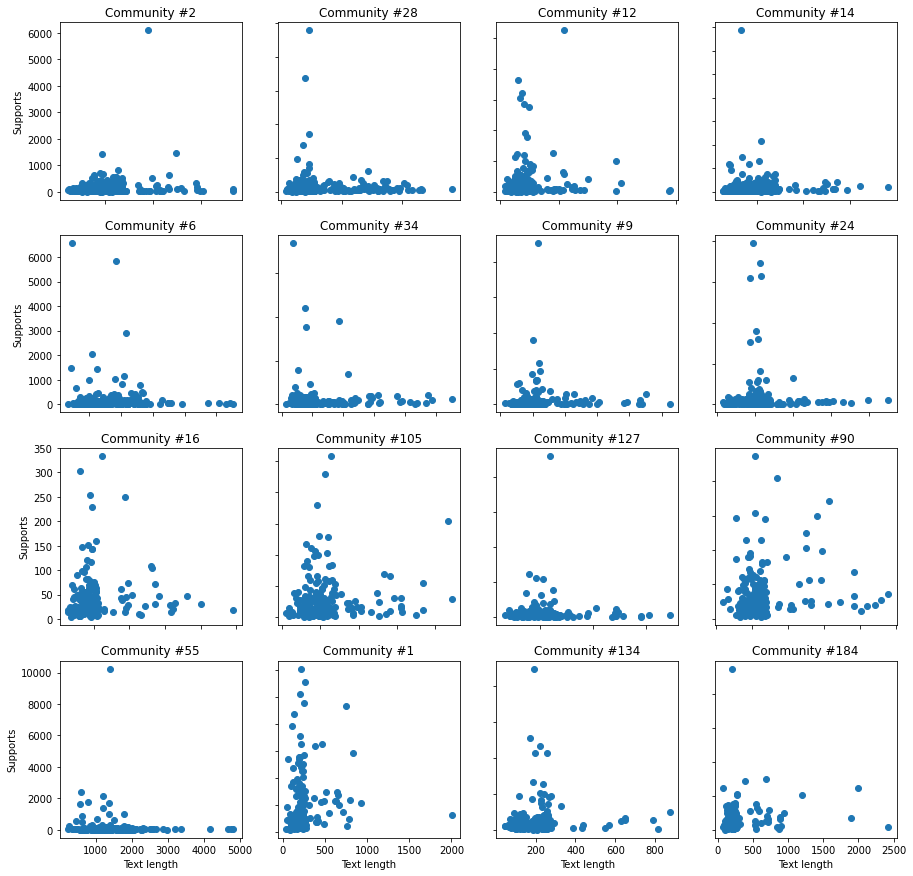

In [ ]:
import math
import matplotlib.pyplot as plt

subplot_size = math.ceil(math.sqrt(len(big_communities)))
fig, axs = plt.subplots(subplot_size,subplot_size,figsize=(15,15))

for i in range(subplot_size):
  for j in range(subplot_size):
    try:
      axs[i, j].scatter(x = community_unique[community_unique['community'] == big_communities[subplot_size*i+j]][['text_length']],
                        y = community_unique[community_unique['community'] == big_communities[subplot_size*i+j]][['supports']])
      axs[i, j].set_title('Community #'+str(big_communities[subplot_size*i+j]))
    except:
      pass

for ax in axs.flat:
    ax.set(xlabel='Text length', ylabel='Supports')
for ax in axs.flat:
    ax.label_outer()

fig.savefig('support_textlenght.png')

Aquí podemos ver que las propuestas super elaboradas no tienden a ser las que más se votan. Dentro de una comunidad, las propuestas con muchos votos son las que tienen una longitud por debajo de la media. Se puede entender que la gente no le gusta leer? Prefiero algo conciso y directo?

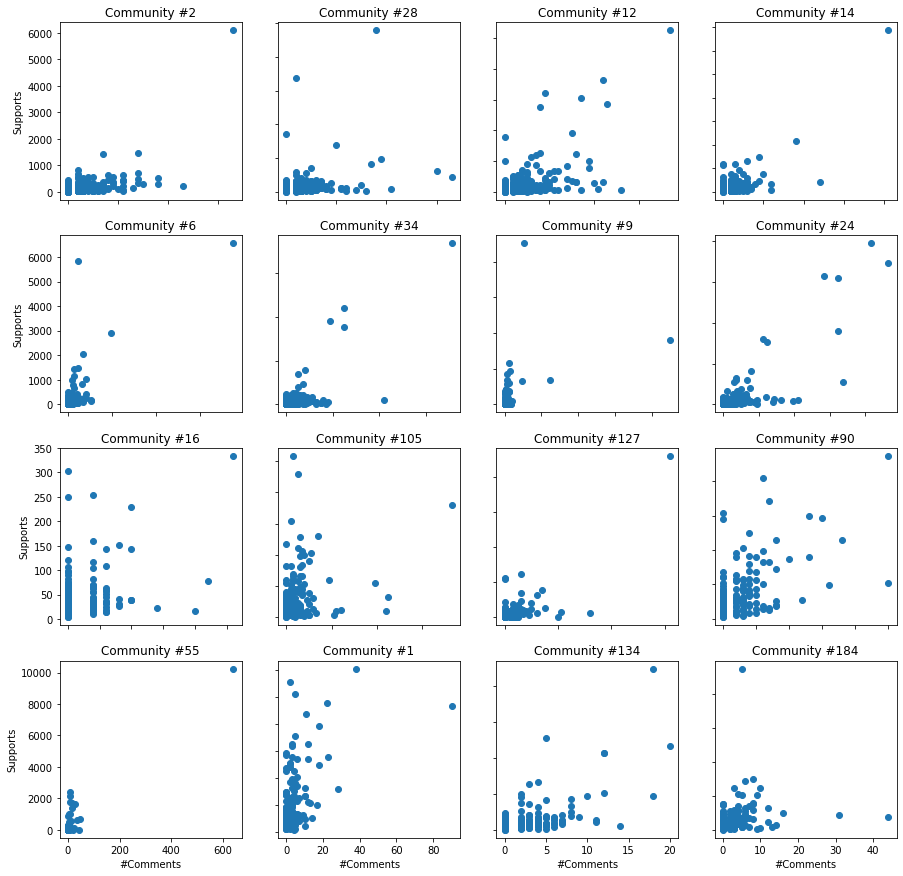

In [ ]:
import math
import matplotlib.pyplot as plt

subplot_size = math.ceil(math.sqrt(len(big_communities)))
fig, axs = plt.subplots(subplot_size,subplot_size,figsize=(15,15))

for i in range(subplot_size):
  for j in range(subplot_size):
    try:
      axs[i, j].scatter(x = community_unique[community_unique['community'] == big_communities[subplot_size*i+j]][['num_comments']],
                        y = community_unique[community_unique['community'] == big_communities[subplot_size*i+j]][['supports']])
      axs[i, j].set_title('Community #'+str(big_communities[subplot_size*i+j]))
    except:
      pass

for ax in axs.flat:
    ax.set(xlabel='#Comments', ylabel='Supports')
for ax in axs.flat:
    ax.label_outer()

fig.savefig('support_comments.png')

La tendencia que se puede ver es que a mayores comentarios, más votos, están bastante correlacionados. Hay excepciones pero pueden ser outliers o simplemente casos particulares de la comunidad

In [ ]:
import math
import matplotlib.pyplot as plt
import datetime

def get_weekday(fecha):
  fecha = str(fecha)
  fecha = fecha.split("-")
  fecha = [int(n) for n in fecha]
  return datetime.datetime(fecha[0],fecha[1],fecha[2]).weekday()

weekdays = [get_weekday(dat) for dat in community_unique['date'].values]
community_unique['week_day'] = weekdays

subplot_size = math.ceil(math.sqrt(len(big_communities)))
fig, axs = plt.subplots(subplot_size,subplot_size,figsize=(15,15))

for i in range(subplot_size):
  for j in range(subplot_size):
    try:
      axs[i, j].scatter(x = community_unique[community_unique['community'] == big_communities[subplot_size*i+j]][['week_day']],
                        y = community_unique[community_unique['community'] == big_communities[subplot_size*i+j]][['supports']])
      axs[i, j].set_title('Community #'+str(big_communities[subplot_size*i+j]))
      
    except:
      pass

for ax in axs.flat:
    ax.set(xlabel='Week day', ylabel='Supports')
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
for ax in axs.flat:
    ax.label_outer()

fig.savefig('supports_weekday.png')

NameError: ignored

Podemos ver que más o menos si se publica el martes/miércoles suele tener más apoyos. Puede ser porque después viene el fin de semana y la gente está libre? Fijarse que va tiene una cumbre en el martes más o menos y despues va cayendo

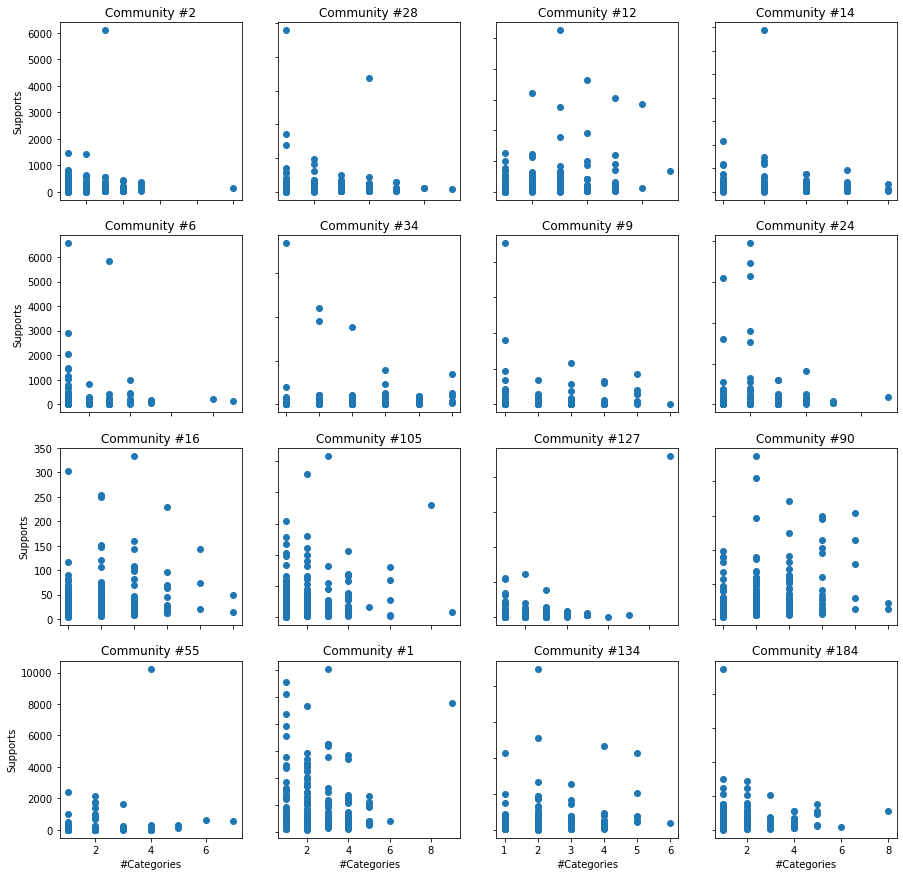

In [ ]:
import math
import matplotlib.pyplot as plt

a = data[['pid','category']].drop_duplicates().groupby('pid').count()[['category']]
a['pid'] = a.index
a.index = range(len(a))
b = data.drop_duplicates('pid')[['pid','supports','community']]
category_count = pd.merge(a,b,on='pid')

subplot_size = math.ceil(math.sqrt(len(big_communities)))
fig, axs = plt.subplots(subplot_size,subplot_size,figsize=(15,15))

for i in range(subplot_size):
  for j in range(subplot_size):
    try:
      axs[i, j].scatter(x = category_count[category_count['community'] == big_communities[subplot_size*i+j]][['category']],
                        y = category_count[category_count['community'] == big_communities[subplot_size*i+j]][['supports']])
      axs[i, j].set_title('Community #'+str(big_communities[subplot_size*i+j]))
    except:
      pass

for ax in axs.flat:
    ax.set(xlabel='#Categories', ylabel='Supports')
for ax in axs.flat:
    ax.label_outer()

fig.savefig('supports_categories.png')

No se puede abusar con las categorías, ni calvo ni con tres pelucas. Tienen que tener una cosa razonable, una o dos, quizá tres.

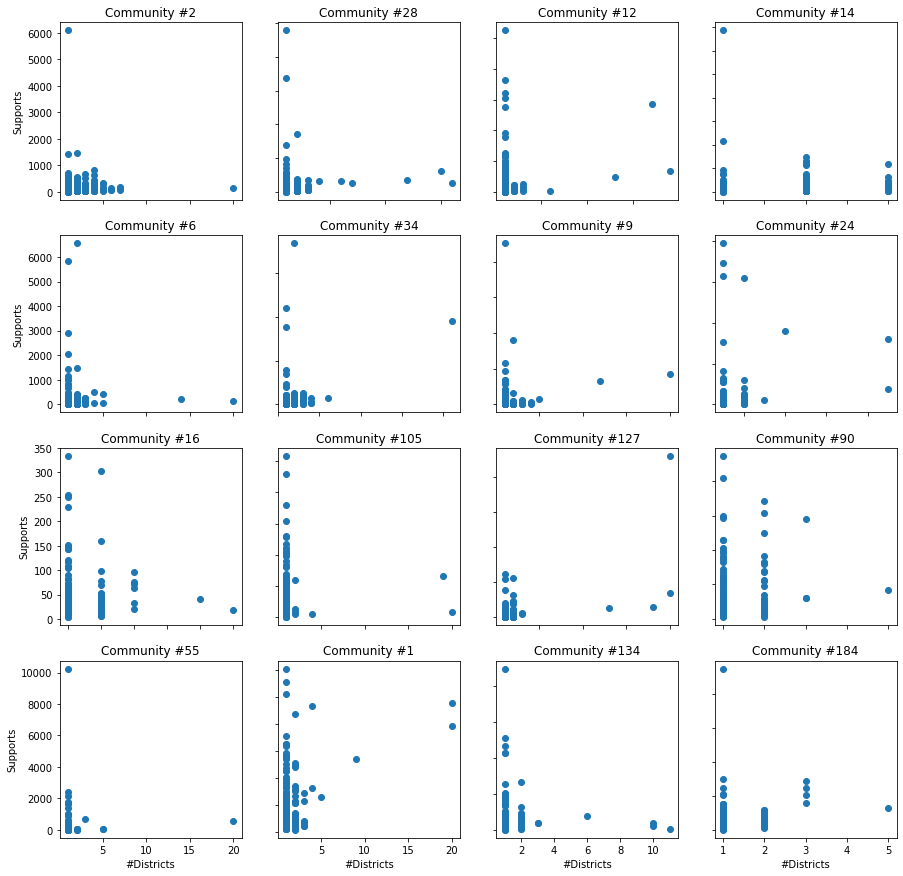

In [ ]:
import math
import matplotlib.pyplot as plt

a = data[['pid','district']].drop_duplicates().groupby('pid').count()[['district']]
a['pid'] = a.index
a.index = range(len(a))
b = data.drop_duplicates('pid')[['pid','supports','community']]
category_count = pd.merge(a,b,on='pid')

subplot_size = math.ceil(math.sqrt(len(big_communities)))
fig, axs = plt.subplots(subplot_size,subplot_size,figsize=(15,15))

for i in range(subplot_size):
  for j in range(subplot_size):
    try:
      axs[i, j].scatter(x = category_count[category_count['community'] == big_communities[subplot_size*i+j]][['district']],
                        y = category_count[category_count['community'] == big_communities[subplot_size*i+j]][['supports']])
      axs[i, j].set_title('Community #'+str(big_communities[subplot_size*i+j]))
    except:
      pass

for ax in axs.flat:
    ax.set(xlabel='#Districts', ylabel='Supports')
for ax in axs.flat:
    ax.label_outer()

fig.savefig('supports_districts.png')

De igual modo que con las categorías, el numero de distritos que son afectados tiene que ser el que toca, no hay que abusar. Es posible tener votos con 4 distritos diferentes, pero parece que la gente le gusta lo concreto, uno dos incluso tres distritos.

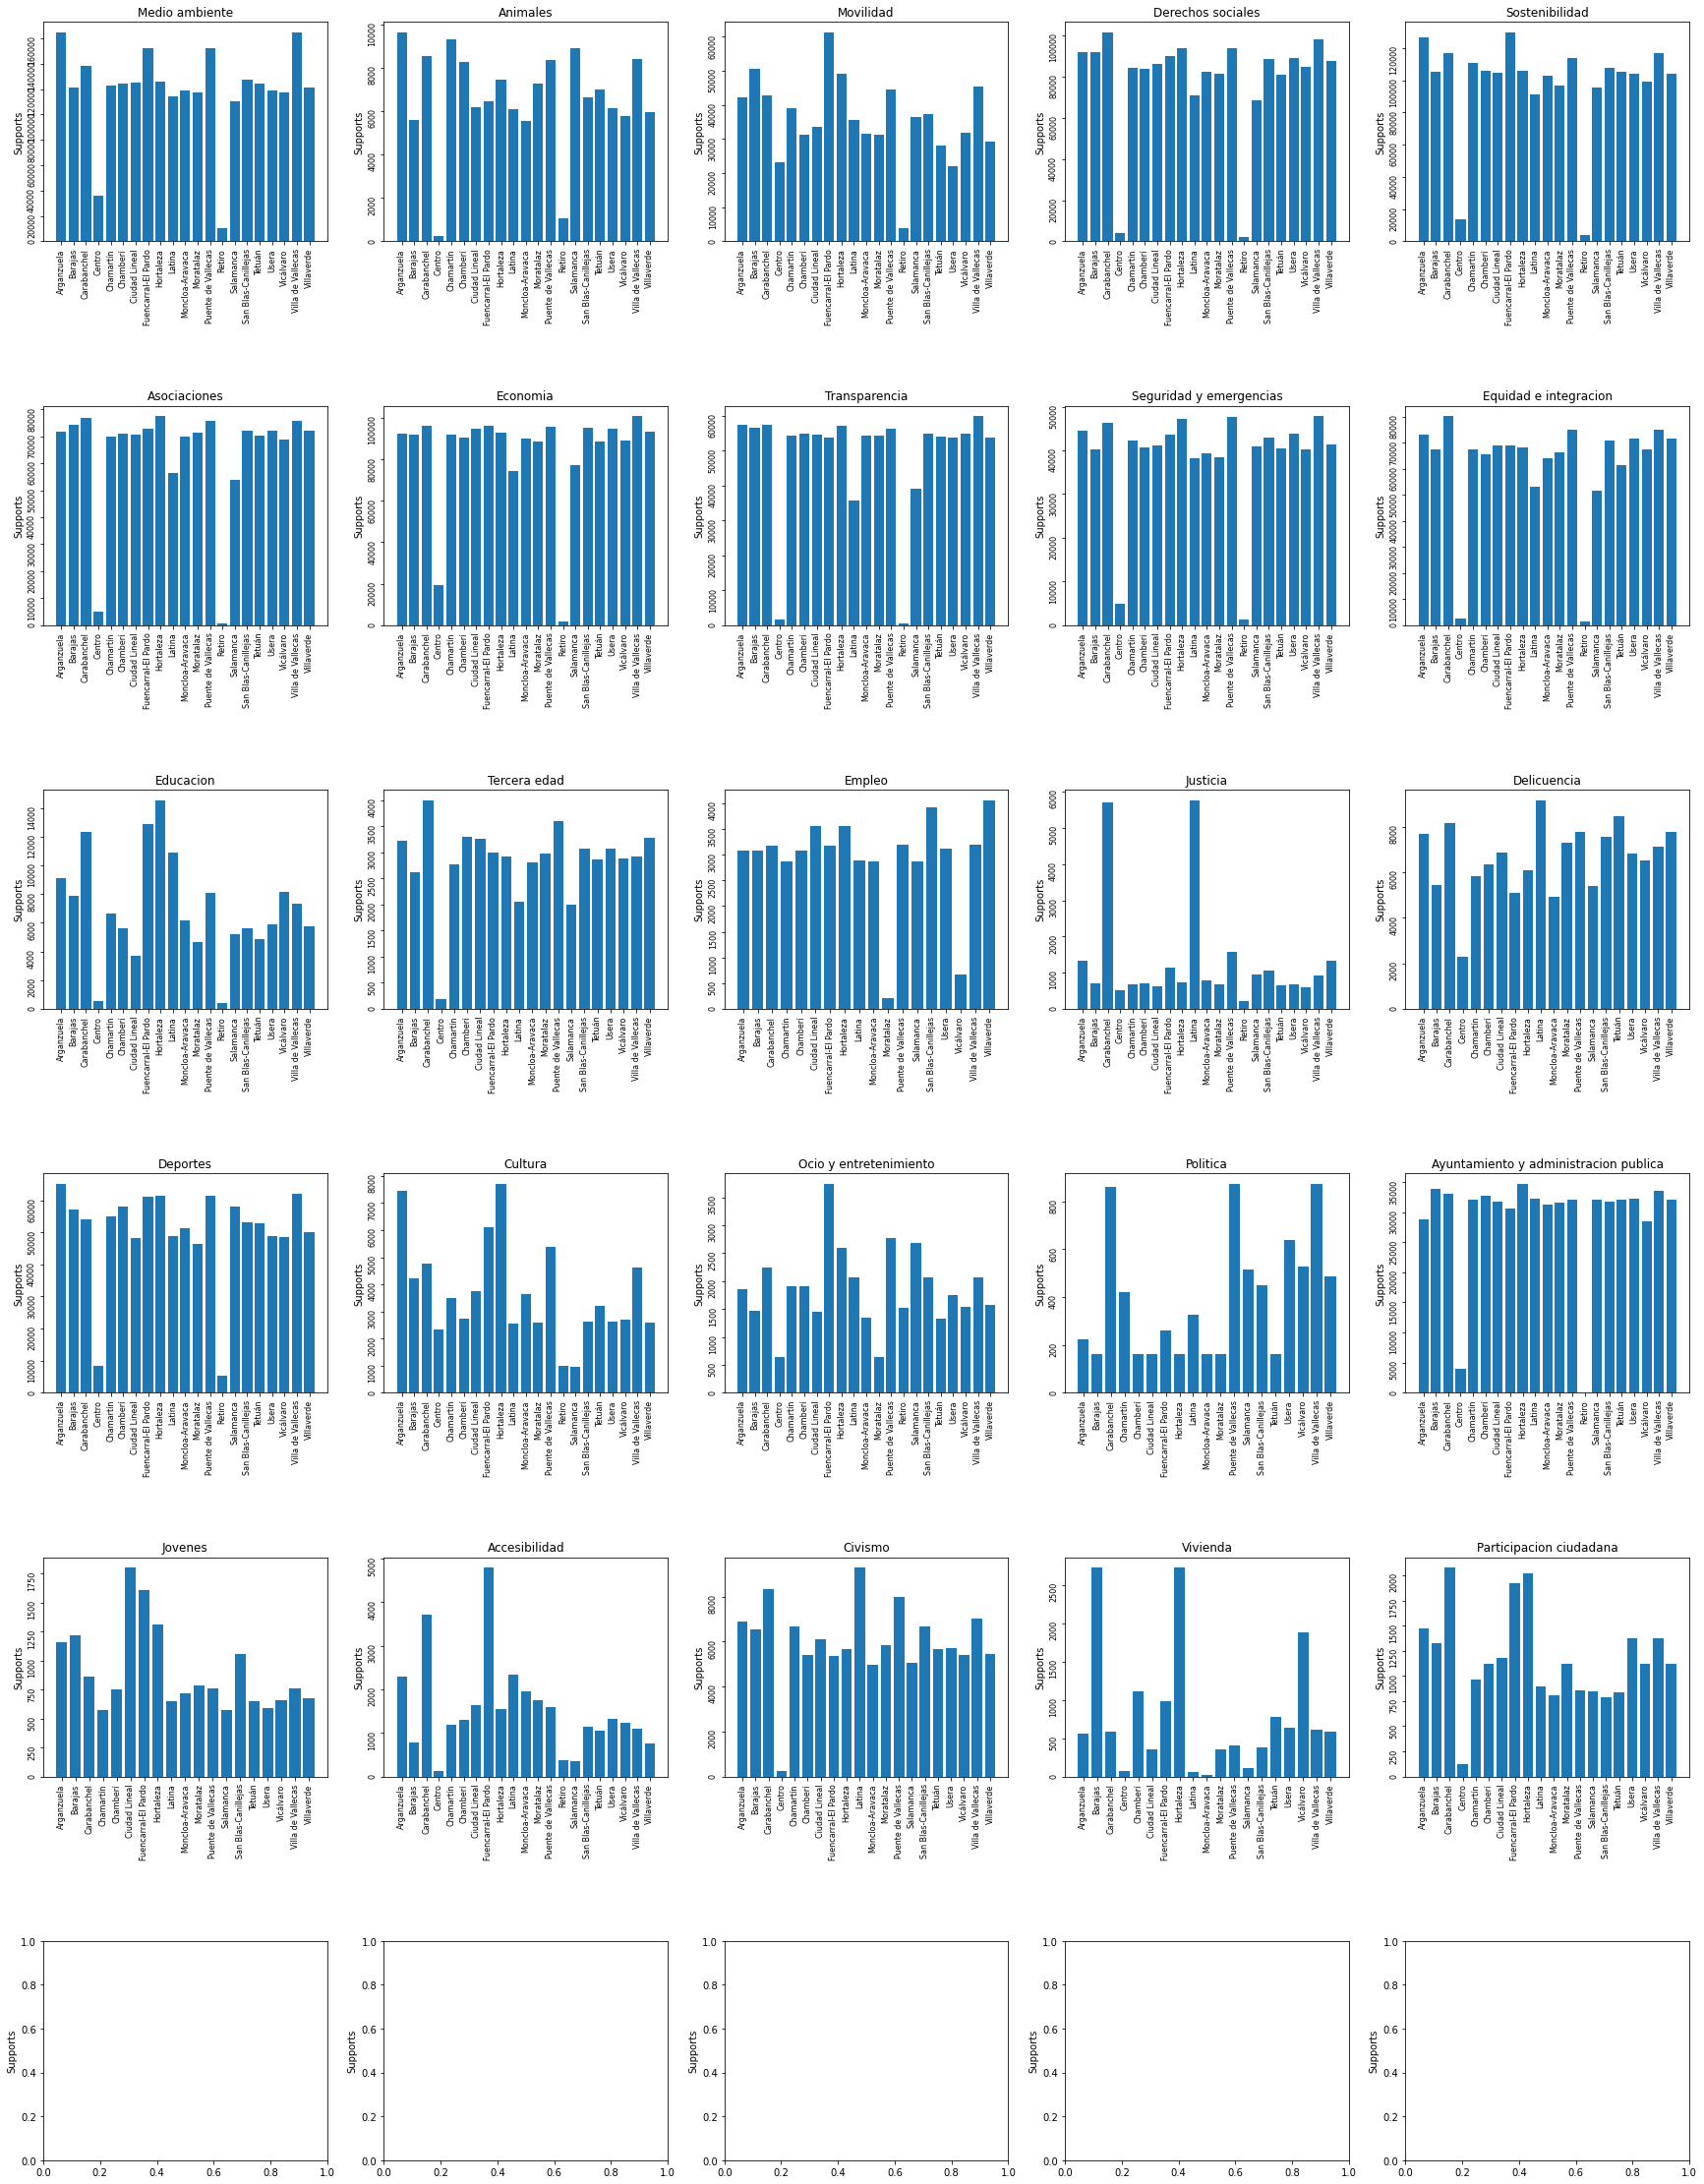

In [ ]:
import math
import matplotlib.pyplot as plt

districts = data['district'].unique()
categories = data['category'].unique()
district_categories = data[['district','category','supports']].groupby(['district','category']).sum()
district_categories = district_categories.reset_index()

district_categories = district_categories[district_categories['district'] != 'Ciudad']  # Este es el distrito general y no me deja ver bien

subplot_size = math.ceil(math.sqrt(len(categories)))
fig, axs = plt.subplots(6,5,figsize=(30,40))
fig.subplots_adjust(hspace = 0.75)

for i in range(6):
  for j in range(5):
    try:
      axs[i,j].bar( x = district_categories[district_categories['category'] == categories[subplot_size*i+j]]['district'],
                    height = district_categories[district_categories['category'] == categories[subplot_size*i+j]]['supports'])
      axs[i, j].set_title(categories[subplot_size*i+j])
      axs[i, j].tick_params(labelrotation=90,labelsize=8)
      axs[i, j].autoscale(enable=True) 
    except:
      pass

for ax in axs.flat:
    ax.set(ylabel='Supports')
# for ax in axs.flat:
    # ax.label_outer()

fig.savefig('categoryimpactperdistrict.png')

La propuesta más votada de cada distrito

In [ ]:
data.sort_values(by='supports', ascending=False).drop_duplicates('pid').drop_duplicates('district')[['district','title', 'category','community','supports']]

,district,title,category,community,supports
51299,Fuencarral-El Pardo,Arborizacion masiva en Madrid,Medio ambiente,11496,20604
5488,Ciudad,Aplicacion del IBI a los bienes inmuebles de l...,Vivienda,664,19136
2927,Vicálvaro,Gratuidad del tlf 010 Inf.Ayuntamiento y 092 P...,Asociaciones,298,16188
51807,Centro,Moratoria turistica en el centro de Madrid,Turismo,11643,11791
5094,Chamartín,Multar a los bancos con viviendas vacias.,Medio ambiente,613,10018
240,Chamberí,Carril bici por la Castellana,Movilidad,39,7908
39670,Arganzuela,Replantar arboles talados,Medio ambiente,6,5840
221,Carabanchel,Cierre del Centro de Internamiento para Extran...,Justicia,37,4848
1218,Moratalaz,Remunicipalizar Las instalaciones deportivas,Ayuntamiento y administracion publica,127,4594
32499,Moncloa-Aravaca,CREACION DE UN BANCO DE ALIMENTOS DE GESTION M...,Derechos sociales,6520,4307


Distribución de participación

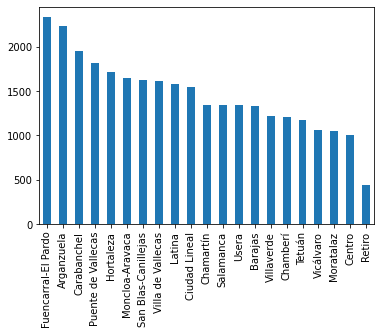

In [ ]:
a = data[data['district'] != 'Ciudad']['district'].value_counts().plot.bar()
a.figure.savefig("district_participation.png")
a

Cantidad de elementos por comunidad

In [ ]:
data[['pid','community']].drop_duplicates('pid')['community'].value_counts()

2        475
28       409
12       367
14       327
6        318
        ... 
13228      1
2987       1
938        1
5032       1
10211      1
Name: community, Length: 13171, dtype: int64

In [ ]:
print('Avg members in communities: ', data[['pid','community']].drop_duplicates('pid')['community'].value_counts().mean())

Avg members in communities:  1.4456761065978285


De que va la comunidad

In [ ]:
for bc in big_communities:
  print("Community #"+str(int(bc))+" is about " + str(data.drop_duplicates('pid')[data['community'] == bc]['category'].value_counts().index[0]))
  print("Top proposals: " )
  print(str(data.drop_duplicates('pid')[data['community'] == bc].sort_values(by='supports', ascending=False)['title'].iloc[0]))
  print(str(data.drop_duplicates('pid')[data['community'] == bc].sort_values(by='supports', ascending=False)['title'].iloc[1]))
  print(str(data.drop_duplicates('pid')[data['community'] == bc].sort_values(by='supports', ascending=False)['title'].iloc[2]))
  print("\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Community #12 is about Movilidad
Top proposals: 
Incluir el BiciMAD en el Abono Transportes
Transbordo gratis entre metro, bus, cercanias zona 1
Abono Transporte gratuito para desempleados.


Community #28 is about Movilidad
Top proposals: 
Aprovechamiento de espacios con malos usos para transformarlos en zonas verdes.
Eliminar los parquimetros de los hospitales
Las motos tambien deben pagar la zona azul y verde


Community #2 is about Movilidad
Top proposals: 
Transporte publico frecuente y economico
Alargar recorrido lineas EMT de Sanchinarro hasta Valdebebas-Carcavas
Crear metro Villaverde-Vallecas


Community #9 is about Movilidad
Top proposals: 
Horario nocturno transporte publico
METRO abierto toda la noche en fines de semana
Reestablecer el servicio de autobuses nocturnos (L)


Community #34 is about Deportes
Top proposals: 
Accesibilidad al metro
Crear carriles bici con separacion de los demas vehiculos
Conectar Anillo Ciclista con la ciudad


Community #24 is about Animales
To

Popularidad de las comunidades

In [ ]:
for bc in big_communities:
  try:
    qty = data[data['district'] != 'Ciudad'].drop_duplicates('pid')[data['community'] == bc]['district'].value_counts()[0]
    ttl = data[data['district'] != 'Ciudad'].drop_duplicates('pid')[data['community'] == bc].shape[0]
    print("Community #"+str(int(bc))+ " has " + str(qty*100/ttl) + "% presence in " + data[data['district'] != 'Ciudad'].drop_duplicates('pid')[data['community'] == bc]['district'].value_counts().index[0])
  except:
    pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Community #2 has 19.335347432024168% presence in Fuencarral-El Pardo
Community #28 has 12.437810945273633% presence in Arganzuela
Community #12 has 13.72549019607843% presence in Barajas
Community #14 has 38.02281368821293% presence in Puente de Vallecas
Community #6 has 10.92896174863388% presence in Fuencarral-El Pardo
Community #34 has 25.170068027210885% presence in Arganzuela
Community #9 has 20.58823529411765% presence in Moncloa-Aravaca
Community #24 has 15.789473684210526% presence in Ciudad Lineal
Community #16 has 17.73049645390071% presence in San Blas-Canillejas
Community #105 has 20.0% presence in Tetuán
Community #127 has 15.517241379310345% presence in Moncloa-Aravaca
Community #90 has 14.583333333333334% presence in Arganzuela
Community #55 has 31.25% presence in Latina
Community #1 has 14.049586776859504% presence in Arganzuela
Community #134 has 13.333333333333334% presence in Latina
Community #184 has 22.388059701492537% presence in Fuencarral-El Pardo


In [ ]:
import pandas as pd
import numpy as np

chunk_size = 1000
chunk_list = []
for i, chunk in enumerate(pd.read_csv('WMD_Distances_FULL.csv', chunksize=chunk_size)):
  if (i % 2 == 0):
    print('Read items: ', i * chunk_size)
  chunk_list.append(chunk)

sim_matrix = pd.concat(chunk_list)

# sim_matrix = sim_matrix.drop(sim_matrix.index[0])
sim_matrix = sim_matrix.drop(sim_matrix.columns[0], axis='columns')

Read items:  0
Read items:  2000
Read items:  4000
Read items:  6000
Read items:  8000
Read items:  10000
Read items:  12000
Read items:  14000
Read items:  16000
Read items:  18000
Read items:  20000


In [ ]:
import pickle
wmd_communities = pickle.load(open('communities_wmd.p','rb'))
max_dist = 6.092210613870716  # Fasterrrrrrrr
sim_means = []

for bc in big_communities:
  suma = 0
  count = 0

  for pid1, com1 in wmd_communities.items():
    if com1 == bc:
      for pid2, com2 in wmd_communities.items():
        if com2 == bc and pid1 != pid2:
          if sim_matrix.iloc[pid1,pid2] != 0:
            suma += sim_matrix.iloc[pid1,pid2]
          else:
            suma += sim_matrix.iloc[pid2,pid1]
          count += 1
  try:
    sim = 1 - ((suma/count)/max_dist)
    print("Community #",bc, ' with ', sim , '% similar between them')
    sim_means.append(sim)
  except e:
    print("err",e)

print('\n----------------------------------------------')
print("Avg Similarity In-Community: " ,sum(sim_means)/len(sim_means))

Community # 2  with  0.38782603738979793 % similar between them
Community # 28  with  0.40699853254784113 % similar between them
Community # 12  with  0.3798736833780987 % similar between them
Community # 14  with  0.3716119332951807 % similar between them
Community # 6  with  0.3755237780411258 % similar between them
Community # 34  with  0.403275317043295 % similar between them
Community # 9  with  0.3777420181794744 % similar between them
Community # 24  with  0.3893351624538435 % similar between them
Community # 16  with  0.3941300143884171 % similar between them
Community # 105  with  0.3959860516796231 % similar between them
Community # 127  with  0.3708511949646389 % similar between them
Community # 90  with  0.3904362505833854 % similar between them
Community # 55  with  0.45972187538723275 % similar between them
Community # 1  with  0.40181359194244914 % similar between them
Community # 134  with  0.3980431446176036 % similar between them
Community # 184  with  0.3761388134423

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

wmd_communities = pickle.load(open('communities_wmd.p','rb'))
max_dist = 6.092210613870716  # Fasterrrrrrrr
bc = 127
plt.figure(figsize=(30,30))
plt_i = 331

for bc in big_communities[:9]:
  n_matrix = []
  for pid1, com1 in wmd_communities.items():
    if com1 == bc:
      n_row = []
      for pid2, com2 in wmd_communities.items():
        if com2 == bc:
          n_row.append(sim_matrix.iloc[pid1,pid2])
      n_matrix.append(n_row)

  n_matrix = np.matrix(n_matrix)

  for i in range(len(n_matrix)):
    for j in range(len(n_matrix)):
      if i<j:
        n_matrix[j,i] = n_matrix[i,j]

  n_matrix = 1-(pd.DataFrame(n_matrix)/max_dist)
  n_matrix[n_matrix<0.55] = 0

  G=nx.from_numpy_matrix(n_matrix.to_numpy())

  plt.subplot(plt_i, title='Community #'+str(int(bc)))
  plt_i += 1 
  edges = G.edges()
  weights = [G[u][v]['weight'] for u,v in edges]
  
  nx.draw(G, pos=nx.spring_layout(G), node_size=50, width=weights)

plt.savefig("big_communities.png")
plt.show()

In [ ]:
max_dist = 6.092210613870716  # Fasterrrrrrrr

norm_sim_matrix = 1 - (sim_matrix/max_dist)
norm_sim_matrix[norm_sim_matrix == 1] = np.NaN

histo = np.zeros(10)

for idxs, row in norm_sim_matrix.iterrows():
  if (idxs % 500 == 0):
    print("Processed rows: ", idxs)
  for item in row:
    offset = 0.1
    placed = False

    if item != np.NaN:
      while placed == False:
        if item < offset:
          histo[int(offset*10)-1] += 1
          placed = True
        else:
          offset = offset + 0.1
        if offset > 1:
          placed=True
      

histo

Processed rows:  0
Processed rows:  500
Processed rows:  1000
Processed rows:  1500
Processed rows:  2000
Processed rows:  2500
Processed rows:  3000
Processed rows:  3500
Processed rows:  4000
Processed rows:  4500
Processed rows:  5000
Processed rows:  5500
Processed rows:  6000
Processed rows:  6500
Processed rows:  7000
Processed rows:  7500
Processed rows:  8000
Processed rows:  8500
Processed rows:  9000
Processed rows:  9500
Processed rows:  10000
Processed rows:  10500
Processed rows:  11000
Processed rows:  11500
Processed rows:  12000
Processed rows:  12500
Processed rows:  13000
Processed rows:  13500
Processed rows:  14000
Processed rows:  14500
Processed rows:  15000
Processed rows:  15500
Processed rows:  16000
Processed rows:  16500
Processed rows:  17000
Processed rows:  17500
Processed rows:  18000
Processed rows:  18500
Processed rows:  19000
Processed rows:  19500
Processed rows:  20000
Processed rows:  20500
Processed rows:  21000
Processed rows:  21500


array([2.35296400e+06, 3.01085000e+05, 3.43047640e+07, 1.78209626e+08,
       1.69128190e+07, 1.06002000e+05, 3.09200000e+03, 0.00000000e+00,
       1.32000000e+02, 0.00000000e+00])

In [ ]:
import pickle
pickle.dump( histo, open( "histo.p", "wb" ) )

In [ ]:
[str(i/10)+"-"+str(round((i/10)+0.1,1)) for i in range(10)]

['0.0-0.1',
 '0.1-0.2',
 '0.2-0.3',
 '0.3-0.4',
 '0.4-0.5',
 '0.5-0.6',
 '0.6-0.7',
 '0.7-0.8',
 '0.8-0.9',
 '0.9-1.0']

Number of similarities between 0.0 and 0.1 : 2352964
Number of similarities between 0.1 and 0.2 : 301085
Number of similarities between 0.2 and 0.3 : 34304764
Number of similarities between 0.3 and 0.4 : 178209626
Number of similarities between 0.4 and 0.5 : 16912819
Number of similarities between 0.5 and 0.6 : 106002
Number of similarities between 0.6 and 0.7 : 3092
Number of similarities between 0.7 and 0.8 : 0
Number of similarities between 0.8 and 0.9 : 132
Number of similarities between 0.9 and 1.0 : 0




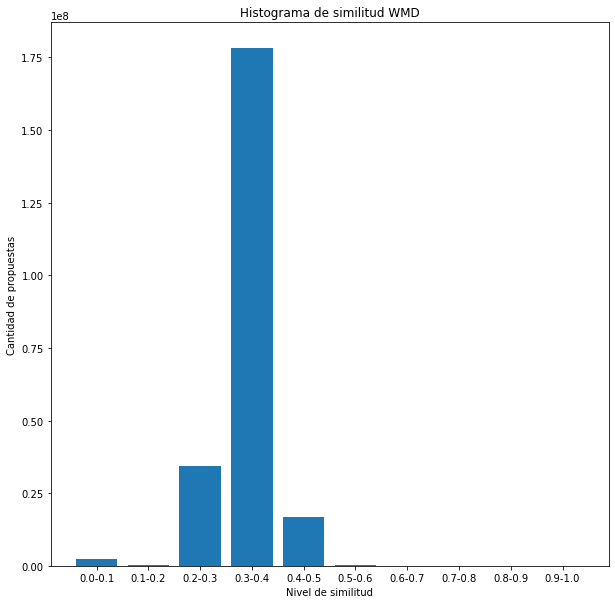

In [ ]:
import matplotlib.pyplot as plt
import math
import pickle
histo = pickle.load(open('histo.p', 'rb'))

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de similitud WMD')
ax.set_ylabel('Cantidad de propuestas')
ax.set_xlabel('Nivel de similitud')
ax.set_xticks(range(10)) # set the position of the x ticks
ax.set_xticklabels([str(i/10)+"-"+str(round((i/10)+0.1,1)) for i in range(15)])
ax.bar(range(10),histo)


offset = 0.0
for i in histo:
  print("Number of similarities between",offset,"and", round(offset+0.1,1), ":", int(i))
  offset = round(offset + 0.1,1)
print("\n")

fig.savefig('sss.png')

# Regresion

In [ ]:
def get_weekday(fecha):
  fecha = str(fecha)
  fecha = fecha.split("-")
  fecha = [int(n) for n in fecha]
  return datetime.datetime(fecha[0],fecha[1],fecha[2]).weekday()

regression_df = data[['pid','text_length','date','num_comments','district','category','supports','community']]
regression_df['weekday'] = [get_weekday(dat) for dat in regression_df['date'].values]
regression_df = regression_df[['pid','text_length','weekday','num_comments','district','category','community','supports']]

regression_df['weekday'] = regression_df['weekday'].astype(str)
regression_df['community'] = regression_df['community'].astype(str)
# regression_df['day'] = range(len(regression_df))

regression_df = pd.get_dummies(regression_df.dropna())
x_cols = regression_df.columns.to_list()
x_cols.remove('supports')
regression_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pid,text_length,num_comments,supports,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,district_Arganzuela,district_Barajas,district_Carabanchel,district_Centro,district_Chamartín,district_Chamberí,district_Ciudad,district_Ciudad Lineal,district_Fuencarral-El Pardo,district_Hortaleza,district_Latina,district_Moncloa-Aravaca,district_Moratalaz,district_Puente de Vallecas,district_Retiro,district_Salamanca,district_San Blas-Canillejas,district_Tetuán,district_Usera,district_Vicálvaro,district_Villa de Vallecas,district_Villaverde,category_Accesibilidad,category_Animales,category_Asociaciones,category_Ayuntamiento y administracion publica,category_Civismo,category_Cultura,category_Delicuencia,...,community_9958,community_9959,community_996,community_9960,community_9961,community_9962,community_9963,community_9964,community_9965,community_9966,community_9968,community_9969,community_997,community_9970,community_9971,community_9972,community_9973,community_9974,community_9975,community_9976,community_9979,community_998,community_9980,community_9981,community_9982,community_9983,community_9984,community_9985,community_9986,community_9987,community_9988,community_9989,community_9990,community_9991,community_9993,community_9994,community_9995,community_9997,community_9998,community_9999
0,0,167,129,2896,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,167,129,2896,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,157,10,134,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,157,10,134,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,168,4,93,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64986,21743,268,0,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64987,21743,268,0,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64988,21744,777,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64989,21744,777,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math

scaler = MinMaxScaler()

X = grouped_regression_df[x_cols].values
y = grouped_regression_df['supports'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

# N = math.ceil(len(X)*0.80)
# X_train = X[:N]
# X_test = X[N:]
# y_train = y[:N]
# y_test = y[N:]

# X_train = pd.DataFrame(X_train, columns = x_cols)
# X_test = pd.DataFrame(X_test, columns = x_cols)
# y_train = pd.DataFrame(y_train, columns = ['supports'])
# y_test = pd.DataFrame(y_test, columns = ['supports'])

# # Normalise
# X_train[['text_length']] = min_max_scaler.fit_transform(X_train[['text_length']])
# X_train[['num_comments']] = min_max_scaler.fit_transform(X_train[['num_comments']])
# X_test[['text_length']] = min_max_scaler.fit_transform(X_test[['text_length']])
# X_test[['num_comments']] = min_max_scaler.fit_transform(X_test[['num_comments']])

# y_train[['supports']] = min_max_scaler.fit_transform(y_train[['supports']])
# y_test[['supports']] = min_max_scaler.fit_transform(y_test[['supports']])

# regressor = LinearRegression()  
# regressor.fit(X_train, y_train)

# coeff_df = pd.DataFrame(regressor.coef_.reshape(-1,1), x_cols, columns=['Coefficient'])  
# coeff_df[:10]

regressor = RandomForestRegressor(n_estimators=10, n_jobs=-1)
regressor.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

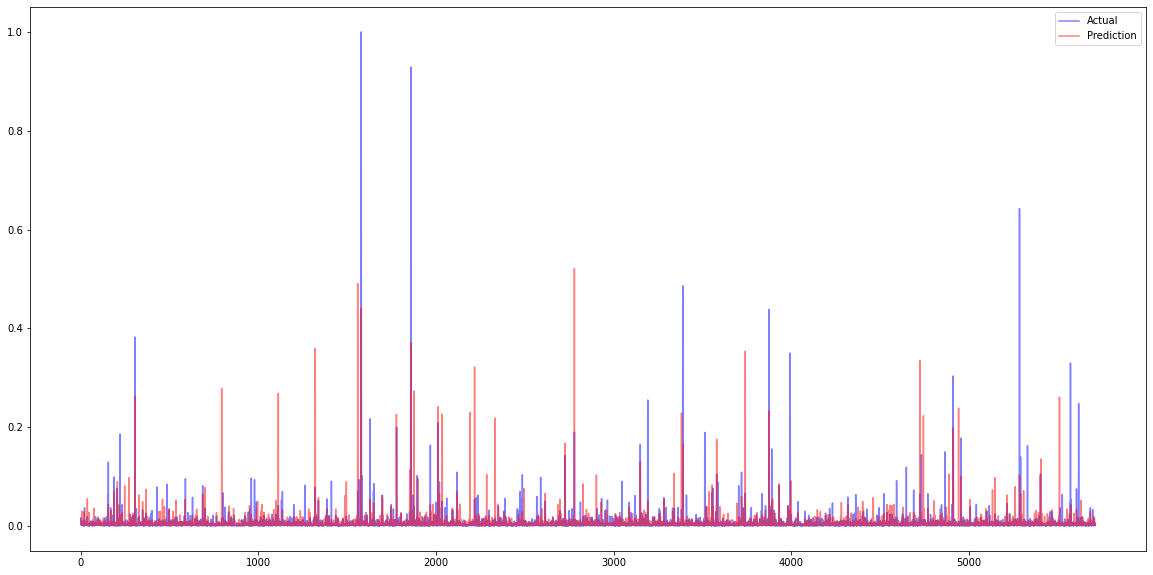

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

y_pred = regressor.predict(X_test)
N = len(y_pred)

plt.plot(range(len(y_test)),y_test,'b',label='Actual',alpha=0.5)
plt.plot(range(len(y_pred[:N])),y_pred[:N],'r',label='Prediction',alpha=0.5)
# plt.plot(range(len(y_test[:N])),y_test[:N],'b-',label='Actual',alpha=0.5)
# plt.plot(range(len(y_pred[:N])),y_pred[:N],'r-',label='Prediction',alpha=0.5)
# plt.plot(range(len(y_pred[:N])),abs(y_pred[:N]-y_test[:N]),'g-',label='Error',alpha=0.5)
plt.legend()


In [ ]:
# Get numerical feature importances
from sklearn.tree import export_graphviz# Export as dot file
importances = list(regressor.feature_importances_)
dic_imp = {}
feature_importances = [(feature, importance) for feature, importance in zip(x_cols, importances)]

for row in feature_importances:
  dic_imp[row[0]] = row[1]

for w in sorted(dic_imp, key=dic_imp.get, reverse=True)[:10]:
  print(w, dic_imp[w])


num_comments 0.38827583802985643
text_length 0.07857500973142523
community_688 0.07705347148158262
weekday_1 0.026456796231435774
community_11258 0.01662872237333748
community_19 0.015926491421619483
community_523 0.0150190848547908
community_298 0.014339826367874309
category_Medio ambiente 0.014160774413459119
community_6475 0.01380423104515836


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.024130317059540118

In [ ]:
regressor.score(X_test,y_test)

0.21172970035436434

# **Export data**

In [ ]:
data[data['district'] != 'Ciudad'].drop_duplicates('pid')

,pid,title,text_length,date,num_comments,district,category,user,supports,community
0,0,Hacer las calles del centro de Madrid peatonales,167,2015-09-15,129,Centro,Medio ambiente,electrocronopio,2896,0
3,1,Crear una zona cercada para perros en Las Tablas,157,2015-09-15,10,Fuencarral-El Pardo,Animales,Marta González,134,1
5,2,Metro nuevo en la linea 1,168,2015-09-15,4,Puente de Vallecas,Movilidad,Daniel Arnau,93,2
6,2,Metro nuevo en la linea 1,168,2015-09-15,4,Tetuán,Movilidad,Daniel Arnau,93,2
11,4,Uso artistico y de promocion del Arco de la V...,436,2015-09-15,7,Moncloa-Aravaca,Urbanismo,Jose E,49,4
...,...,...,...,...,...,...,...,...,...,...
64983,21742,Acabar con los botellones en el parque Cerro d...,204,2019-09-07,0,Latina,Medio ambiente,alvaro2390,5,15111
64984,21742,Acabar con los botellones en el parque Cerro d...,204,2019-09-07,0,Latina,Seguridad y emergencias,alvaro2390,5,15111
64985,21743,Soterramiento vias tren desde estacion Princip...,268,2019-09-08,0,Moncloa-Aravaca,Medio ambiente,Alfonso Goiriz,6,15112
64986,21743,Soterramiento vias tren desde estacion Princip...,268,2019-09-08,0,Moncloa-Aravaca,Movilidad,Alfonso Goiriz,6,15112


In [ ]:
data[['district','category','pid']][data['district']!='Ciudad'].groupby(['district','category']).count().reset_index().to_excel("category_amountper_district.xls")
data[['district','category','pid']][data['district']!='Ciudad'].groupby(['district','category']).count()

pid
district   category                                  
Arganzuela Accesibilidad                           25
           Animales                                61
           Asociaciones                            83
           Ayuntamiento y administracion publica   22
           Civismo                                 14
...                                               ...
Villaverde Tercera edad                            13
           Transparencia                           36
           Turismo                                  1
           Urbanismo                              184
           Vivienda                                 2

[615 rows x 1 columns]

In [ ]:
data[['district','community','pid']][data['district']!='Ciudad'][data['community'].isin(big_communities[:10].to_list())].groupby(['district','community']).count().to_excel("community_amountper_district.xls")
data[['district','community','pid']][data['district']!='Ciudad'][data['community'].isin(big_communities[:10].to_list())].groupby(['district','community']).count()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


pid
district   community     
Arganzuela 1           62
           2           45
           6           27
           9           31
           12          16
...                   ...
Villaverde 90           7
           105         10
           127         18
           134          1
           184          2

[329 rows x 1 columns]

In [ ]:
data[['district','category','date','pid']].groupby(['district','category','date']).count().reset_index().to_excel("category_amountper_district_date.xls")
data[['district','category','date','pid']].groupby(['district','category','date']).count()

pid
district   category      date           
Arganzuela Accesibilidad 2015-09-16    1
                         2015-09-22    1
                         2015-09-29    2
                         2015-10-11    2
                         2015-11-24    2
...                                  ...
Villaverde Urbanismo     2019-03-20    1
                         2019-04-08    1
                         2019-05-03    1
                         2019-06-10    1
           Vivienda      2015-09-23    2

[32498 rows x 1 columns]

In [ ]:
data[['district','community','date','pid']][data['community'].isin(big_communities[:10].to_list())].groupby(['district','community','date']).count().reset_index().to_excel("community_amountper_district_date.xls")
data[['district','community','date','pid']][data['community'].isin(big_communities[:10].to_list())].groupby(['district','community','date']).count()

pid
district   community date           
Arganzuela 2         2015-09-15    5
                     2015-09-24    2
                     2015-09-25   10
                     2015-10-04    1
                     2015-11-04    1
...                              ...
Villaverde 34        2016-07-17    2
                     2016-09-05    1
                     2017-08-08    2
           105       2015-09-16    9
                     2015-10-03    1

[3564 rows x 1 columns]

In [ ]:
data[['pid','district','date']].groupby(['district','date']).count().reset_index().to_excel("proposal_by_date.xls")
data[['pid','district','date']].groupby(['district','date']).count().reset_index()

,district,date,pid
0,Arganzuela,2015-09-15,210
1,Arganzuela,2015-09-16,113
2,Arganzuela,2015-09-17,61
3,Arganzuela,2015-09-18,75
4,Arganzuela,2015-09-19,18
...,...,...,...
7738,Villaverde,2019-05-19,1
7739,Villaverde,2019-06-10,3
7740,Villaverde,2019-06-16,4
7741,Villaverde,2019-06-17,2


In [ ]:
sorted(big_communities[:10])

[2, 6, 9, 12, 14, 16, 24, 28, 34, 105]

# **Nearest proposal**

In [ ]:

### TREETAGGER
!curl https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/tree-tagger-linux-3.2.2.tar.gz -o tree-tagger-linux-3.2.2.tar.gz
!curl https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/tagger-scripts.tar.gz -o tagger-scripts.tar.gz
!curl https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/install-tagger.sh -o install-tagger.sh
!curl https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/spanish.par.gz -o spanish.par.gz
!sh install-tagger.sh

# Hunspell -> Spell checking
#!curl https://github.com/elastic/hunspell/raw/master/zips/es_ES.zip -o es_ES.zip
!curl https://raw.githubusercontent.com/LibreOffice/dictionaries/master/es/es_ANY.aff -o es_ES.aff >> /dev/null
!curl https://raw.githubusercontent.com/LibreOffice/dictionaries/master/es/es_ANY.dic -o es_ES.dic >> /dev/null
!sudo apt update >> /dev/null
!sudo apt-get install python3.6-dev >> /dev/null
!sudo apt-get install libhunspell-dev >> /dev/null
!pip install hunspell >> /dev/null

#Spacy -> Get noun chunks
!pip install -U spacy >> /dev/null
!python -m spacy download es_core_news_md >> /dev/null

# Textdistance -> Similarity between list of strings (Jaccard index)
!pip install textdistance >> /dev/null

# Imports
import es_core_news_md
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize

import textdistance
import hunspell
import re

# Adding custom names to spellchecking dictionaries:
# Neighborhoods
geo_neighborhoods = db_query_select('name','geo_neighborhoods',encoding='utf-8')
geo_neighborhoods = [element[0] for element in geo_neighborhoods]

# Districts
geo_districts = db_query_select('name','geo_districts',encoding='utf-8')
geo_districts = [element[0] for element in geo_districts]

# Streets
geo_streets = db_query_select('distinct street','geo_locations',encoding='utf-8')
geo_streets = [element[0].title() for element in geo_streets]

# Callejero Madrid
with open('/content/drive/My Drive/TFM/callejero_madrid.txt',encoding='iso-8859-1') as f:
  callejero = f.readlines()
callejero = [c.replace("\n",'') for c in callejero]

# Other Words
with open('/content/drive/My Drive/TFM/custom_dic.txt') as f:
    custom_words = f.readlines()

# Add
with open("es_ES.dic", "a") as myfile:

  myfile.write("\n")
  for element in geo_neighborhoods:
    myfile.write(element+"\n")
  for element in geo_districts:
    myfile.write(element+"\n")
  for element in geo_streets:
    myfile.write(element+"\n")
  for element in custom_words:
    myfile.write(element+"\n")
  for element in callejero:
    myfile.write(element+"\n")

# NLTK -> Stopwords
nltk.download('stopwords')
nltk.download('punkt')
spanish_stopwords = stopwords.words('spanish') # STOPWORDS
spanish_stopwords.append(',')

nlp = es_core_news_md.load() # SPACY

corrector = hunspell.HunSpell('es_ES.dic','es_ES.aff')  #CORRECTOR


# TREETAGGER WRAPPER
!pip install treetaggerwrapper
import treetaggerwrapper
import os
!export TAGDIR='/content/cmd'
os.environ['TAGDIR'] = '/content'

tagger = treetaggerwrapper.TreeTagger(TAGLANG='es')

In [ ]:
def lemmatize(text, exceptions):
  # Dont lemmatize exceptions

  import subprocess

  res_lemmas = []

  cmd = "echo \'" + text + "\' | cmd/tree-tagger-spanish"
  # print(cmd[:50])
  ps = subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
  output = ps.communicate()[0]
  # print(output)
  output = output.decode("utf-8").split("\n")

  output = output[2:-2]

  # treetagger_result = tagger.tag_text(text)
  # treetagger_result = !echo {text} | cmd/tree-tagger-spanish
  # treetagger_result = treetagger_result[2:-1]
  treetagger_result = output
  lemmas = [lemma.split('\t') for lemma in treetagger_result]
  # lemmas = [lemma[2] if lemma[2] != '<unknown>' and lemma[2] != '@card@' else lemma[0] for lemma in lemmas]
  for lemma in lemmas:
    # Get the lemma
    if lemma[2] != '<unknown>' and lemma[2] != '@card@':
      actual_lemma = lemma[2]
    else:
      actual_lemma = lemma[0]

    # Get the category
    # actual_lemma += "|"
    # actual_lemma += lemma[1]
    res_lemmas.append(actual_lemma)

  return res_lemmas

def clean_symbols(text, symbols = '/' ):
  for sym in symbols:
    if sym in text:
      text = text.replace(sym,' ')
  return text

def clean_stopwords(txt, exceptions):
  txt = txt.lower()

  filtered_sentence = [] 
  for e in exceptions:
    if bool(re.search(r'\b' + e.lower() + r'\b', txt)):
      filtered_sentence.append(e)
      txt = re.sub(r'\b' + e.lower() + r'\b', '', txt)

  word_tokens = word_tokenize(txt) 

  for w in word_tokens: 
    if w not in spanish_stopwords and len(w) > 2:
      filtered_sentence.append(w) 

  return " ".join(filtered_sentence)

def clean_stopwords_spacy(text, exceptions):
  text = text.lower()

  non_stopwords = []
  for e in exceptions:
    if bool(re.search(r'\b' + e.lower() + r'\b', text)):
      non_stopwords.append(e)
      text = re.sub(r'\b' + e.lower() + r'\b', '', text)

  doc = nlp(text)
  for token in doc:
    if token.is_stop == False:
      non_stopwords.append(token.text)

  return ' '.join(non_stopwords)

def get_noun_chunks(txt):
  doc = nlp(txt)
  words = []

  for i in doc.noun_chunks:
    # print(i)
    words.append(clean_stopwords(str(i)))
  words = list(filter(None, words))

  # Debería devolver una unica vez la palabra o todas las apariciones?
  # return words
  return list(set(words))

def spell_checking(text):
  newstr = []
  # print("Spellchecking '" + text + "'")

  for i in text.split(' '):
    newstr.append(corrector.suggest(i)[0] if not corrector.spell(i) and corrector.suggest(i) != [] else i)

  return ' '.join(newstr).lower()

def get_similar_nouns(words):
  context = []
  n = 3 # Only the three first words

  for i in words:
    try:
      context.append([i])  # Add the origin word(s) before similars

      # If it's a compound noun -> separate it
      if (' ' in i):
        i = i.split(' ')

      actual_context_raw = wordvectors.most_similar_cosmul(positive=i)[:n]
      context.append([word[0] for word in actual_context_raw])
    except:
      pass

  context = functools.reduce(operator.iconcat, context, []) # Flatten the list
  return context

def lemmatize2(text):
  return ' '.join(lemmatize(text, lemma_exceptions)).replace('\n','')

In [ ]:
##### LEMMA EXCEPTIONS
lemma_exceptions = []

# Neighborhoods
geo_neighborhoods = db_query_select('name','geo_neighborhoods',encoding='utf-8')
geo_neighborhoods = [element[0] for element in geo_neighborhoods]

# Districts
geo_districts = db_query_select('name','geo_districts',encoding='utf-8')
geo_districts = [element[0] for element in geo_districts]

# Callejero
with open('/content/drive/My Drive/TFM/callejero_madrid.txt',encoding='utf-8') as f:
  callejero = f.readlines()
callejero = [c.replace("\n",'') for c in callejero]

# Añadir mis palabritas
lemma_exceptions += geo_neighborhoods
lemma_exceptions += geo_districts
lemma_exceptions += callejero

lemma_exceptions.sort(key=len)  # Ordenar por longitud para que no cambie palabras sueltas, primero intenta cambiar por el largo
lemma_exceptions.reverse()

select name from geo_neighborhoods 
select name from geo_districts 


In [ ]:
# Already processed documents
file_nouns = open('/content/drive/My Drive/lemmatized_data_2',"r")
p_documents = file_nouns.readlines()
p_documents = [i.replace('\n','') for i in p_documents]

# New proposal
file_nouns = open('my_proposal.txt',"r")
my_proposal = file_nouns.readlines()
my_proposal = [i.replace('\n','') for i in my_proposal]
my_proposal = ' '.join(my_proposal)

my_proposal

'Construir un recinto para mascotas en Plaza de Castilla  Creacion de una zona para poder pasear a los perros donde puedan estar sueltos  En una zona como Plaza de Castilla es difícil encontrar una zona donde se puedan sacar a los animales a pasear tranquilamente, donde no molesten. La propuesta sería crear una zona cerrada y/o vallada para que los perros puedan estar sueltos y jugar, con árboles, fuentes... Esto podría hacer que los animales no molesten a los peatones de la zona y que los perros puedan hacer pipi sin ensuciar la calle. '

In [ ]:
# Process new proposal
# Clean symbols
my_proposal = clean_symbols(my_proposal, symbols='/\.,()-')
# Spellcheck
my_proposal = spell_checking(my_proposal)
# Clean stopwords
my_proposal = clean_stopwords(my_proposal, lemma_exceptions)
my_proposal = clean_stopwords_spacy(my_proposal, lemma_exceptions)
# Lemmaitze
my_proposal = lemmatize2(my_proposal)

my_proposal

'Castilla fuente plaza construir recinto mascota creación zona pasear perro poder suelto zona difícil encontrar zona poder sacar animal pasear tranquilo molestar proponer crear zona cerrado vallada perro poder suelto jugar árbol animal molestar peatón zona perro poder pipí ensuciar calle'

In [ ]:
#Word2Vec

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Download spanish model binary
!wget -q http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz 
# Unzip
!gzip -d -q SBW-vectors-300-min5.bin.gz

# Load model
w2v_file = 'SBW-vectors-300-min5.bin'
model = KeyedVectors.load_word2vec_format(w2v_file, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
import numpy as np
import multiprocessing as mp
import datetime

def calc_wmd_distance(existing_id):
  # print("Computing distance with: ", existing_id)
  existing_proposal = p_documents[existing_id]
  distances[existing_id] = model.wmdistance(list(set(existing_proposal.split())), list(set(my_proposal.split())))

N = len(p_documents)
# titles = db_query_select('title','proposals')

print("Allocating shared memory...")
distances = mp.Array('d', N) 
print("OK!\n")

# Ejecucion en paralelo
nprocs = mp.cpu_count()*2
print(f"Number of CPU cores: {nprocs}")
print("Mapping workload...")
pool = mp.Pool(processes=nprocs)

print("Starting parallel execution...")
start_time = time.time()
_ = pool.map(calc_wmd_distance, range(N))
elapsed_time = time.time() - start_time
print("Finishing parallel execution...")

# Results
distances = list(distances)
print("\nElapsed time: ", datetime.timedelta(seconds=elapsed_time))
print('Most similar proposal: "', titles[distances.index(min(distances))][0],'"')
print('Minimum distance: ', min(distances))
print('Similarity: ', round((1 - (min(distances)/max([x for x in distances if x != np.inf])))*100,2), '%')


Allocating shared memory...
OK!

Number of CPU cores: 8
Mapping workload...
Starting parallel execution...
Finishing parallel execution...

Elapsed time:  0:04:44.852998
Most similar proposal: " CREACION DE UN PARQUE CANINO-PIPICAN EN EL CANAVERAL "
Minimum distance:  2.636014277800262
Similarity:  51.37 %
